In [1]:
#Import libraries
from __future__ import print_function, division
from future.utils import iteritems

In [12]:
#More libraries
import networkx as nx
import nltk
nltk.download('punkt')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding as LLE
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Semiu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [16]:
#Initialize WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [4]:
#Function to extract the text (CVE descriptions)
def extract_text_corpus():
    
    cve_text_corpus = []
    
    java_cve_text = pd.read_csv("C:\\Users\\Semiu\\Documents\\java-codesecurity\\JavaVulData\\JavaVulData.csv")
    
    for cve in java_cve_text['vulnerability_description']:
        cve_text_corpus.append(cve)
        
    return cve_text_corpus

In [5]:
#extract_text_corpus return list to a variable
list_of_CVEs = extract_text_corpus()

In [8]:
#Create stop words from fundamental English stop words
stopwords = set(w.rstrip() for w in open(r'C:\Users\Semiu\Documents\java-codesecurity\text-classification-CVE-Commits\stopwords.txt'))

# Add more stopwords specific to this problem - as seen in the raw data
stopwords = stopwords.union({
    'java', 'se', 'vulnerability', 'sdk', 'remote', 'oracle', 'database', 'server', 'attacker', 'sap', 'netweaver', 'android',
'ibm', 'embedded', 'product', 'solution', 'manager', 'xstream', 'allows', 'an', 'unauthenticated', 'component', 'issue',
'discovered', 'noise', 'apache', 'xwiki', 'junit', 'discovered', 'unsafe', 'code', 'netscape', 'microsoft', 'machine', 'virtual',
'bea', 'navigator', 'serversocket', 'weblogic', 'vm', 'development', 'kit', 'jre', 'unspecified', 'unknown', 'sun', 'runtime', 
'environment', 'and', '2d', 'web', 'confidentiality', 'integrity', 'unknown', 'vectors', 'products', 'suite', 'in', 'the', 'availability',
'update', 'mobile', 'cicso', 'mobility', 'tomcat', 'update', 'in', 'earlier', 'openjdk', 'red', 'hat', 'related', 'postgresql', 'netflix',
'issue','deployment', 'version', 'attack', 'version', 'compromise', 'i', 'sandbox', 'sandboxed', 'this', 'result', })

In [14]:
#Tokenization function
def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) # split string into words (tokens)
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove any digits, i.e. "7.0"
    return tokens

In [17]:
# create a word-to-index map so that we can create our word-frequency vectors later
# let's also save the tokenized versions so we don't have to tokenize again later
cve_index_map = {}
current_index = 0
all_tokens = []
all_cves = []
index_word_map = []

for java_cve in list_of_CVEs:
    try:
        java_cve = java_cve.encode('ascii', 'ignore') # this will throw exception if bad characters
        java_cve = java_cve.decode('utf-8')
        all_cves.append(java_cve)
        tokens = my_tokenizer(java_cve) #Call the my_tokenizer function for each cve in the list_of_CVEs
        all_tokens.append(tokens)
        for token in tokens:
            if token not in cve_index_map:
                cve_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e:
        print(e)

In [18]:
# Token to vector functon --input matrices - just indicator variables for this example - works better than proportions
def tokens_to_vector(tokens):
    x = np.zeros(len(cve_index_map))
    for t in tokens:
        i = cve_index_map[t]
        x[i] += 1
    return x

In [19]:
#Creating a term-document matrix
N = len(all_tokens) #Number of tokens
D = len(cve_index_map) #D= Documents, Number of CVEs
X = np.zeros((D, N)) # terms will go along rows, documents along columns
i = 0
for tokens in all_tokens:
    X[:,i] = tokens_to_vector(tokens)
    i += 1

In [20]:
#
def d(u, v):
    diff = u - v
    return diff.dot(diff)

In [21]:
#
def cost(X, R, M):
    cost = 0
    for k in range(len(M)):
        diff = X - M[k]
        sq_distances = (diff * diff).sum(axis=1)
        cost += (R[:,k] * sq_distances).sum()
    return cost

In [22]:
#Plot K-Means Clustering algorithm result
def plot_k_means(X, K, index_word_map, max_iter=20, beta=1.0, show_plots=True):
    N, D = X.shape
    M = np.zeros((K, D))
    R = np.zeros((N, K))
    exponents = np.empty((N, K))

    # initialize M to random
    for k in range(K):
        M[k] = X[np.random.choice(N)]

    costs = np.zeros(max_iter)
    for i in range(max_iter):
        # step 1: determine assignments / resposibilities
        # is this inefficient?
        for k in range(K):
            for n in range(N):
                # R[n,k] = np.exp(-beta*d(M[k], X[n])) / np.sum( np.exp(-beta*d(M[j], X[n])) for j in range(K) )
                exponents[n,k] = np.exp(-beta*d(M[k], X[n]))

        R = exponents / exponents.sum(axis=1, keepdims=True)

        # step 2: recalculate means
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()

        costs[i] = cost(X, R, M)
        if i > 0:
            if np.abs(costs[i] - costs[i-1]) < 10e-5:
                break

    if show_plots:
        #Save scatetr plot instead of showing it

        random_colors = np.random.random((K, 3))
        colors = R.dot(random_colors)
        plt.figure(figsize=(80.0, 80.0))
        plt.scatter(X[:,0], X[:,1], s=300, alpha=0.9, c=colors)
        
        annotate1(X, index_word_map)
        # plt.show()
        plt.savefig("test.png")


    #Print out the words in each of the clusters
    hard_responsibilities = np.argmax(R, axis=1) # is an N-size array of cluster identities
    # let's "reverse" the order so it's cluster identity -> word index
    cluster2word = {}
    for i in range(len(hard_responsibilities)):
        word = index_word_map[i]
        cluster = hard_responsibilities[i]
        
    if cluster not in cluster2word:
        cluster2word[cluster] = []
        cluster2word[cluster].append(word)

    # print out the words grouped by cluster
    for cluster, wordlist in cluster2word.items():
        print("cluster", cluster, "->", wordlist)

    return M, R


In [25]:
#Annotating the plot to know which dot is what word, with random moving of the words to avoid collision
def annotate1(X, index_word_map, eps=0.1):
    N, D = X.shape
    placed = np.empty((N, D))
    
    for i in range(N):
        x, y = X[i]
        
        # if x, y is too close to something already plotted, move it
        close = []
        
        x, y = X[i]
        for retry in range(3):
            for j in range(i):
                diff = np.array([x, y]) - placed[j]
                
                # if something is close, append it to the close list
                if diff.dot(diff) < eps:
                    close.append(placed[j])
                    
                if close:
                    # then the close list is not empty
                    x += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
                    
                    y += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
                    
                    close = [] # so we can start again with an empty list
                    
                else:
                    # nothing close, let's break
                    break
                    
    placed[i] = (x, y)
                
    plt.annotate(
        text=index_word_map[i],
        xy=(X[i,0], X[i,1]),
        xytext=(x, y),
        arrowprops={
            'arrowstyle' : '->',
            'color' : 'black',
        }
    )
    print("vocab size:", current_index)
    
    #Maybe return the lifted one in the next cell

vocab size: 4292
cluster 362 -> ['configurator']


(array([[ 4.55556530e+01, -9.95001904e+01],
        [-5.18462985e+01, -1.06682112e+01],
        [-9.45871594e+01, -8.85543458e+01],
        [-7.02311781e+01, -1.02310617e+02],
        [-6.89144130e+01,  3.20873293e+01],
        [ 3.49110815e+01,  6.00645442e+01],
        [ 3.05946680e+00,  2.58465962e+01],
        [-5.17838262e+01, -2.03772897e+01],
        [-8.36728787e+00, -5.19681066e+01],
        [-6.71651819e+01, -3.45582265e+01],
        [-3.93353197e-01,  2.01007461e+01],
        [-1.09872340e+01,  3.04425097e+01],
        [-5.02392992e-01, -1.08385004e+02],
        [-5.21578486e+01,  3.17533912e+01],
        [ 3.27094155e+01,  7.27204837e+01],
        [-2.58538876e-01,  6.62692102e+01],
        [-2.81537266e+01, -4.34891421e+01],
        [ 2.67539872e+01,  1.48201077e+02],
        [-9.86958981e+01, -2.76862805e+01],
        [ 2.08376472e+01,  3.27319911e+01],
        [-1.05643513e+02,  9.55155897e+01],
        [ 4.42352786e+01, -6.08549907e+01],
        [ 3.00465143e+01,  2.765

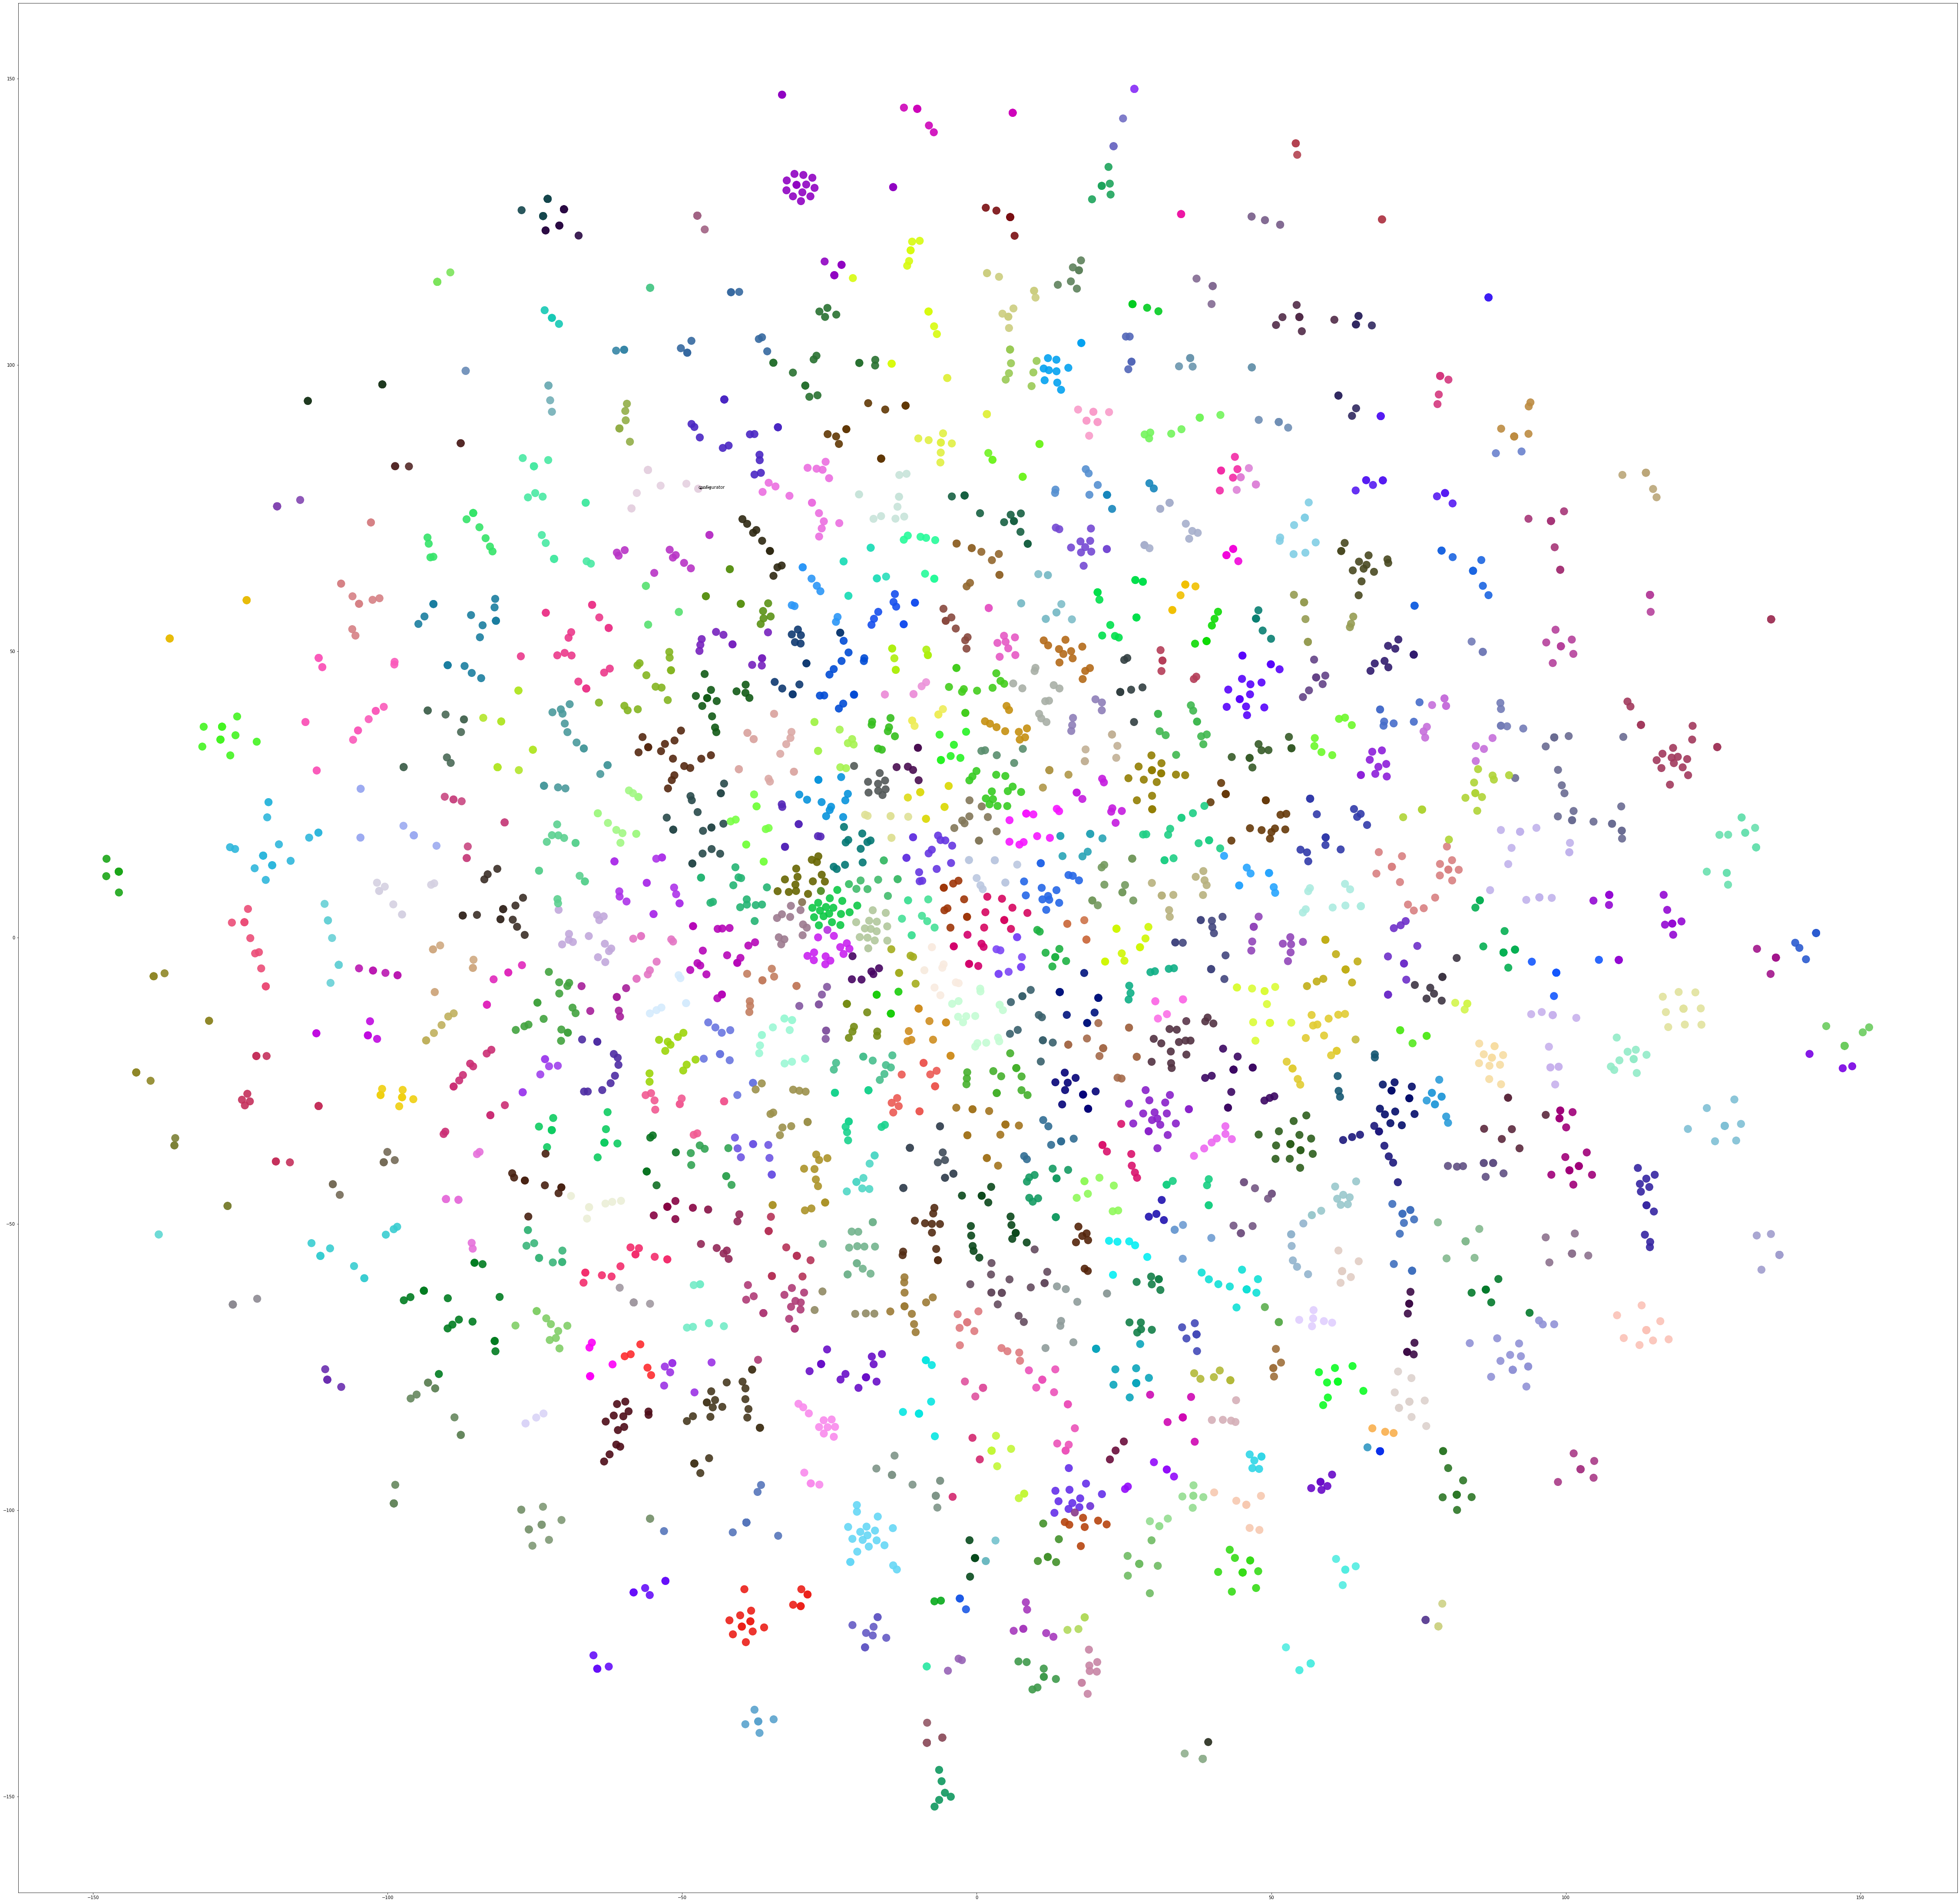

In [26]:
transformer = TfidfTransformer()
    
X = transformer.fit_transform(X).toarray()
    
#Dimensionality reduction
reducer = TSNE()
Z = reducer.fit_transform(X)
    
plot_k_means(Z[:,:2], current_index//10, index_word_map, show_plots=True)